# Calculating Rate per Link
* import libraries
* create the RSE to site mapping
* get the data +/- 5 days
* calculate the rates per link
* plot plot plot

In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Get transfers from ElasticSearch for the date DATE+/-DELTA days

In [19]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
site1='BNL-ATLAS'
site2='NDGF-T1'
DATE = '2017-08-01'  # yyyy-mm-dd
DELTA = 5
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-DELTA, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)

In [20]:
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=1)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
data=[]
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
for res in scroll:
    r = res['_source']
    # filter only the transfers between DATE and DATE+1day
    #if (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') < dt.datetime.strptime(DATE,'%Y-%m-%d'))or(dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') > (dt.datetime.strptime(DATE,'%Y-%m-%d')+dt.timedelta(days=1))):
    #    continue
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([r['src_rse'],r['dst_rse'],r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
    if not count%100000 : print (count)
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['SRC', 'DST', 'ACT', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
#data['QUEUE_T'] = data.STARTED - data.SUBMITTED
#data['NET_T'] = data.ENDED - data.STARTED
data['RATE'] = data.SIZE / (data.ENDED - data.STARTED)
src_sites = [rse2site[rse] for rse in data.SRC.values]
dst_sites = [rse2site[rse] for rse in data.DST.values]
data['SRC_SITE'] = src_sites
data['DST_SITE'] = dst_sites
print('Documents:', len(data))

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
Reading took 213.21311950683594 seconds.
Documents: 1642801


#### Calculate some stats for CERN - BNL Link

In [21]:
cut = data.where(data.SRC_SITE == site2).dropna()
cut = cut.where(cut.DST_SITE == site1).dropna()
pd.set_option('display.float_format', lambda x: '%.02f' % x)
cut.describe()
cut.head()

,SRC,DST,ACT,SIZE,SUBMITTED,STARTED,ENDED,RATE,SRC_SITE,DST_SITE
167,NDGF-T1_DATADISK,BNL-OSG2_DATADISK,Production Output,155828267.00,1501579098.00,1501579100.00,1501579125.00,6233130.68,NDGF-T1,BNL-ATLAS
577,NDGF-T1_DATADISK,BNL-OSG2_DATADISK,Production Output,150773116.00,1501579098.00,1501579100.00,1501579109.00,16752568.44,NDGF-T1,BNL-ATLAS
873,NDGF-T1_DATADISK,BNL-OSG2_DATADISK,Express,2958589.00,1501568155.00,1501568156.00,1501568161.00,591717.80,NDGF-T1,BNL-ATLAS
1092,NDGF-T1_DATADISK,BNL-OSG2_DATADISK,Data Consolidation,80902401.00,1501588163.00,1501588164.00,1501588175.00,7354763.73,NDGF-T1,BNL-ATLAS
1702,NDGF-T1_DATADISK,BNL-OSG2_DATADISK,Production Input,6345073028.00,1501567645.00,1501567647.00,1501567740.00,68226591.70,NDGF-T1,BNL-ATLAS


In [22]:
cut = data.where(data.DST_SITE == site2).dropna()
cut = cut.where(cut.SRC_SITE == site1).dropna()
pd.set_option('display.float_format', lambda x: '%.02f' % x)
cut.describe()

,SIZE,SUBMITTED,STARTED,ENDED,RATE
count,33782.00,33782.00,33782.00,33782.00,33782.00
mean,499862936.44,1501605821.94,1501615906.40,1501616062.33,inf
std,725084564.66,27856.56,25484.52,25409.10,nan
min,346.00,1501536250.00,1501543093.00,1501545602.00,48.94
25%,86579139.50,1501580501.00,1501598904.50,1501599239.00,1042035.74
50%,175360459.50,1501626201.50,1501627876.50,1501628076.50,6492384.00
75%,410157281.25,1501626369.00,1501635904.00,1501635961.75,16741975.00
max,10748195543.00,1501631787.00,1501644233.00,1501646684.00,inf


#### Calculate the rates per minute

In [23]:
delta = (dt.datetime.strptime(DATE, '%Y-%m-%d') - epoch).total_seconds()
src_rate = {}
link_rate = {}
dst_rate = {}
src_files = {}
link_files = {}
dst_files = {}

st = time.time()
for row in data.itertuples():
    src = rse2site[row.SRC]
    link = rse2site[row.SRC]+'__'+rse2site[row.DST]
    dst = rse2site[row.DST]
    start = int((row.STARTED - delta)/60)
    end = int((row.ENDED - delta)/60)
    if src not in src_rate.keys():
        src_rate[src] = [0]*1440
        src_files[src] = [0]*1440
    if link not in link_rate.keys():
        link_rate[link] = [0]*1440
        link_files[link] = [0]*1440
    if dst not in dst_rate.keys():
        dst_rate[dst] = [0] * 1440
        dst_files[dst] = [0] * 1440
    scaled_rate = row.RATE * ((row.ENDED-row.STARTED)/((end+1 - start)*60))
    for i in range(start, end+1):
        if i < 0 or i >= 1440:
            continue
        else:
            src_rate[src][i] += scaled_rate
            link_rate[link][i] += scaled_rate
            dst_rate[dst][i] += scaled_rate
            src_files[src][i] += 1
            link_files[link][i] += 1
            dst_files[dst][i] += 1
print(time.time() - st)

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


27.453171253204346


### Plot for CERN / BNL Link

In [24]:
# the date index is from delta to delta+1 day in seconds.
date_index = range(int(delta), int(delta)+24*60*60, 60)
date_index = list(map(dt.datetime.utcfromtimestamp,date_index))

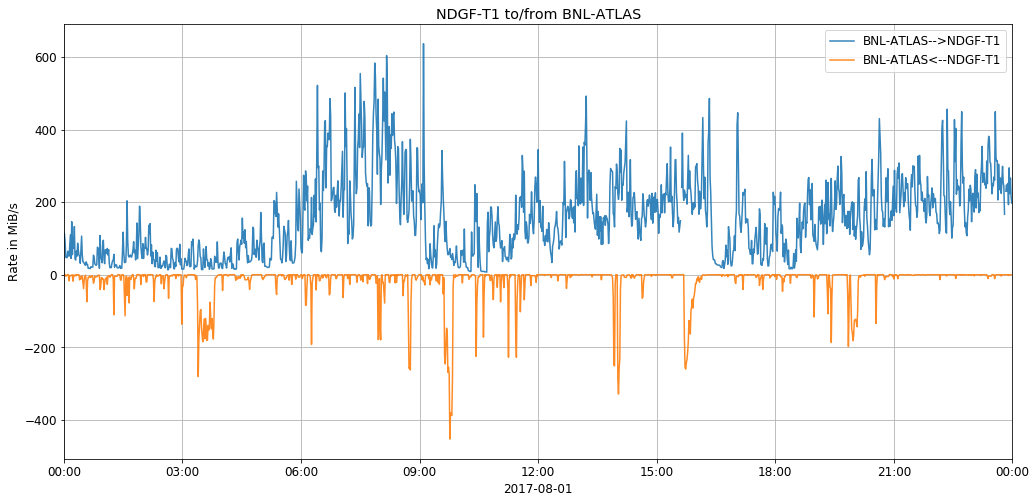

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#fig, ax = plt.subplots()
plt.title(site2 + ' to/from '+site1)
plt.plot(date_index, np.array(link_rate[site1+'__'+site2])/(1024*1024),'', alpha=0.9, label=site1+'-->'+site2)
plt.plot(date_index, -np.array(link_rate[site2+'__'+site1])/(1024*1024),'', alpha=0.9, label=site1+'<--'+site2)
#plt.yscale('log')
plt.xlim(dt.datetime.utcfromtimestamp(delta),dt.datetime.utcfromtimestamp(delta+24*60*60))
#plt.ylim(-100,100)
plt.xlabel(DATE)
plt.ylabel('Rate in MiB/s')
ax=plt.gca()
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

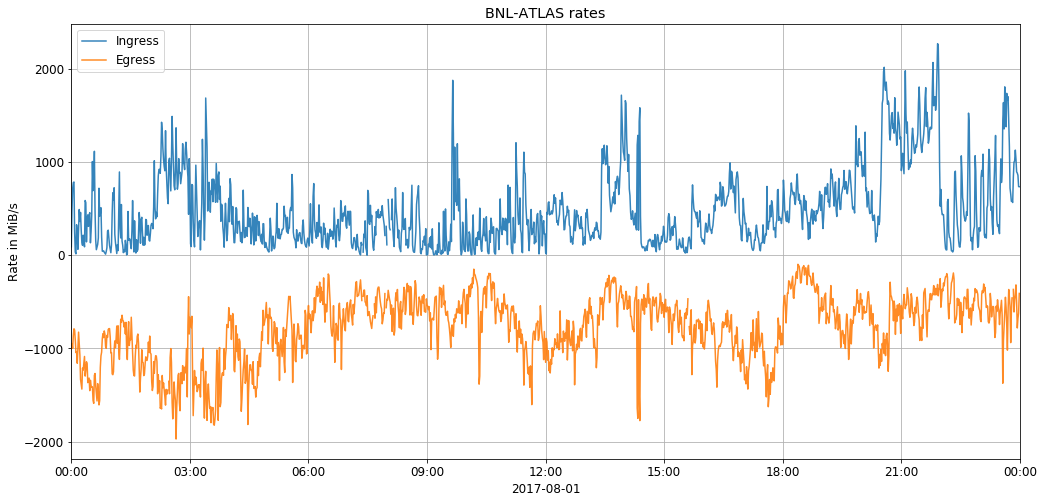

In [27]:
#fig, ax = plt.subplots()
plt.title(site1 + ' rates')
plt.plot(date_index, np.array(dst_rate[site1])/(1024*1024),'', alpha=0.9, label='Ingress')
plt.plot(date_index, -np.array(src_rate[site1])/(1024*1024),'', alpha=0.9, label='Egress')
#plt.yscale('log')
plt.xlim(dt.datetime.utcfromtimestamp(delta),dt.datetime.utcfromtimestamp(delta+24*60*60))
#plt.ylim(-100,100)
plt.xlabel(DATE)
plt.ylabel('Rate in MiB/s')
ax=plt.gca()
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [11]:
for x,y in zip(date_index,np.array(link_rate[site1+'__'+site2])/(1024*1024)):
    print(x,y)

2017-08-01 00:00:00 1.00129072401
2017-08-01 00:01:00 1.00129072401
2017-08-01 00:02:00 1.00129072401
2017-08-01 00:03:00 1.00129072401
2017-08-01 00:04:00 2.45500720872
2017-08-01 00:05:00 1.00129072401
2017-08-01 00:06:00 1.00129072401
2017-08-01 00:07:00 0.0
2017-08-01 00:08:00 0.0
2017-08-01 00:09:00 0.0
2017-08-01 00:10:00 0.0
2017-08-01 00:11:00 0.0
2017-08-01 00:12:00 0.0
2017-08-01 00:13:00 0.0
2017-08-01 00:14:00 0.0
2017-08-01 00:15:00 0.0
2017-08-01 00:16:00 13.7386193699
2017-08-01 00:17:00 9.78081491258
2017-08-01 00:18:00 3.00597685443
2017-08-01 00:19:00 1.57548754215
2017-08-01 00:20:00 0.911593778928
2017-08-01 00:21:00 10.4207049608
2017-08-01 00:22:00 9.81070069472
2017-08-01 00:23:00 11.8085134109
2017-08-01 00:24:00 2.90940649509
2017-08-01 00:25:00 0.911593778928
2017-08-01 00:26:00 0.911593778928
2017-08-01 00:27:00 1.95072480043
2017-08-01 00:28:00 0.0
2017-08-01 00:29:00 0.0
2017-08-01 00:30:00 0.0
2017-08-01 00:31:00 0.0
2017-08-01 00:32:00 0.0
2017-08-01 00:3

2017-08-01 13:00:00 16.1328601128
2017-08-01 13:01:00 21.4136527386
2017-08-01 13:02:00 23.9356822603
2017-08-01 13:03:00 26.7000305553
2017-08-01 13:04:00 20.0552240259
2017-08-01 13:05:00 19.2779673782
2017-08-01 13:06:00 5.30459594925
2017-08-01 13:07:00 4.13437788685
2017-08-01 13:08:00 3.2857320355
2017-08-01 13:09:00 4.50704935326
2017-08-01 13:10:00 5.70152664648
2017-08-01 13:11:00 2.63044134816
2017-08-01 13:12:00 4.33509425547
2017-08-01 13:13:00 1.56991258489
2017-08-01 13:14:00 1.56991258489
2017-08-01 13:15:00 1.56991258489
2017-08-01 13:16:00 7.19569414642
2017-08-01 13:17:00 1.26686708
2017-08-01 13:18:00 1.26686708
2017-08-01 13:19:00 1.26686708
2017-08-01 13:20:00 15.8011284426
2017-08-01 13:21:00 15.3981982592
2017-08-01 13:22:00 1.42675010796
2017-08-01 13:23:00 1.54306421978
2017-08-01 13:24:00 1.20805491642
2017-08-01 13:25:00 3.99373817479
2017-08-01 13:26:00 1.16649932261
2017-08-01 13:27:00 1.16649932261
2017-08-01 13:28:00 1.88777388131
2017-08-01 13:29:00 1.35